https://advances.sciencemag.org/content/6/37/eaba1190 

In [2]:
data='../data/'
d8='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE122nnn/GSE122460/suppl/GSE122460_D8_CD13_UMI.csv.gz'
d16='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE118nnn/GSE118258/suppl/GSE118258_UMI.csv.gz'
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sn
import scipy.cluster.hierarchy as spc
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [8]:
!wget  -P {data} -nc {d8}

File ‘../data/GSE122460_D8_CD13_UMI.csv.gz’ already there; not retrieving.



In [ ]:
!gzip -d ../data/GSE122460_D8_CD13_UMI.csv

In [4]:
!wget  -P {data} -nc {d16}

File ‘../data/GSE118258_UMI.csv.gz’ already there; not retrieving.



In [ ]:
!gzip -d ../data/GSE118258_UMI.csv.gz

In [10]:
f='GSE118258_UMI.csv'
f='GSE122460_D8_CD13_UMI.csv'
df=pd.read_csv(data+f,index_col=0)
df=df.T
adata = sc.AnnData(df)
adata

AnnData object with n_obs × n_vars = 7680 × 32643

In [11]:
adata.write(data+'science2020_d8.h5ad')
adata = sc.read(data+'science2020_d8.h5ad')
adata

AnnData object with n_obs × n_vars = 7680 × 32643

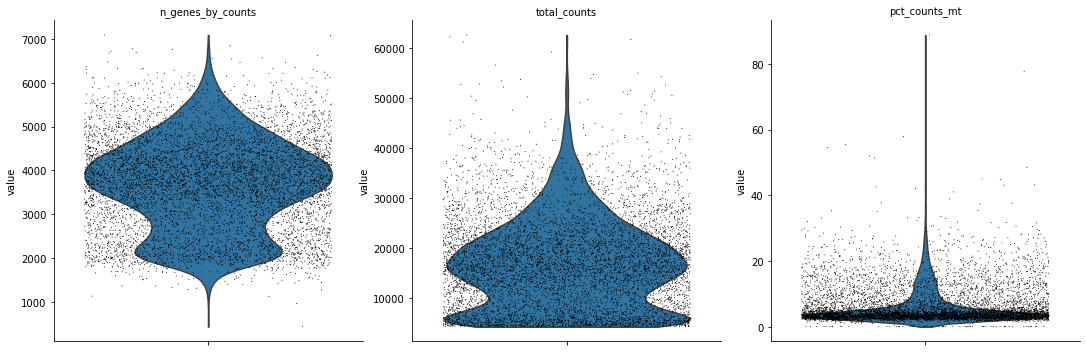

In [12]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [13]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 7679 × 17463
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

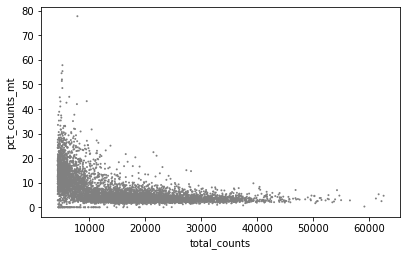

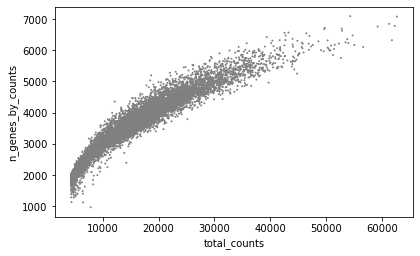

In [14]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [15]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata

View of AnnData object with n_obs × n_vars = 7621 × 17463
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

/Users/mahdi/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


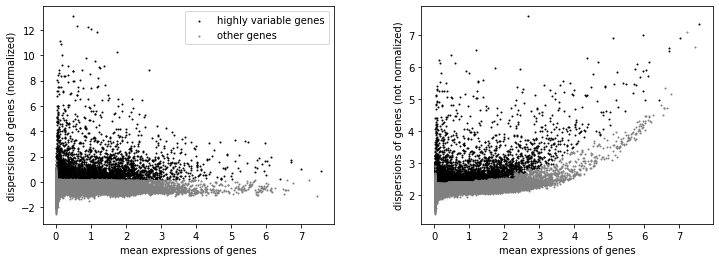

In [16]:
sc.pp.normalize_total(adata, target_sum=1e5)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=10, min_disp=0.2)
sc.pl.highly_variable_genes(adata)

In [17]:
adata=adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 7621 × 4800
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [ ]:
df=adata.to_df()
mart=pd.read_csv(data+'mart_export.txt',sep='\t',index_col=0)
df.columns=mart.loc[df.columns]['Gene name']
df.shape

In [21]:
tf=pd.read_csv('http://humantfs.ccbr.utoronto.ca/download/v_1.01/TF_names_v_1.01.txt',index_col=0,header=None)
mir=df.columns[df.columns.str.startswith('MIR')]

In [22]:
df=df.loc[:,df.columns.intersection(tf.index.append(mir))]
df.shape

(7621, 233)

In [23]:
#meta=pd.read_csv('https://ftp.ncbi.nlm.nih.gov/geo/series/GSE122nnn/GSE122460/suppl/GSE122460_Annotation.txt.gz',sep='\t',index_col=0)
#df=df.loc[meta[meta.prefix=='CD13pos'].index]

In [24]:
df=df[df.columns[df.mean()>0]]
df.shape

(7621, 233)

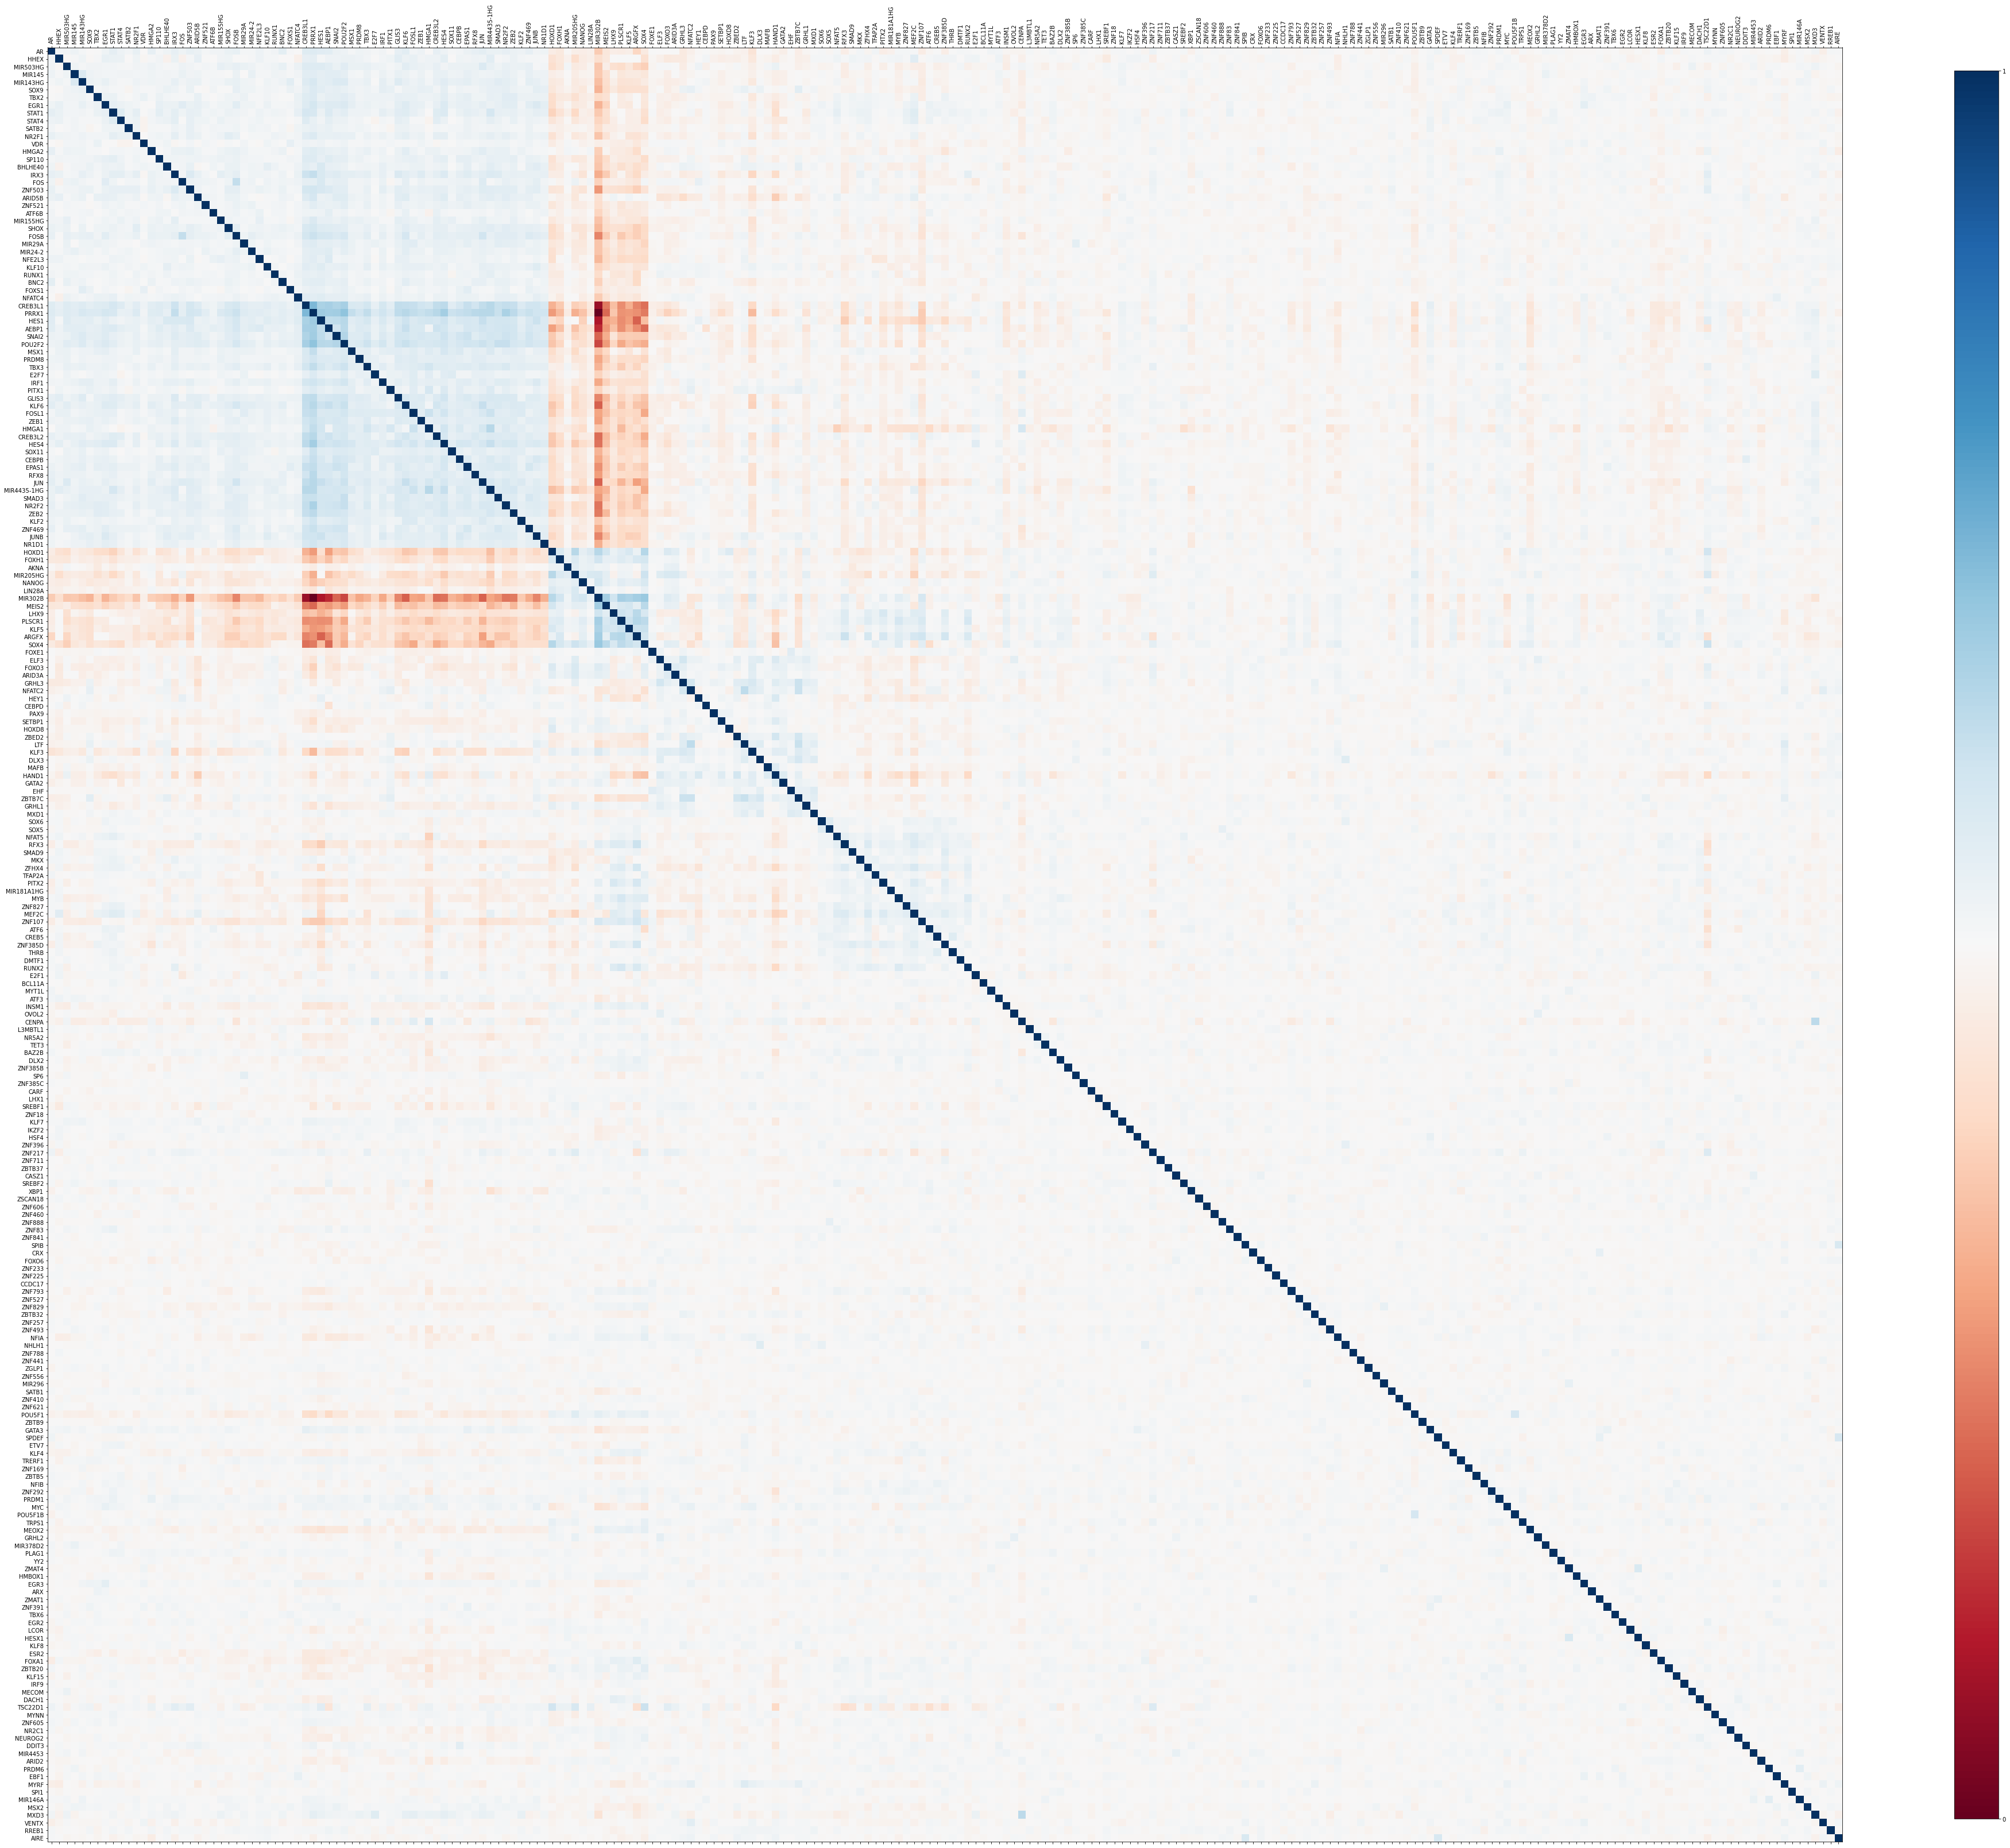

In [25]:
corr= df.corr()
offset = mcolors.TwoSlopeNorm(vmin=corr.min().min(),vcenter=0., vmax=1)
X =corr.values
d = spc.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = spc.linkage(d, method='ward')
ind = spc.fcluster(L, 0.5*d.max(), 'distance')
columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df = df.reindex(columns, axis=1)
size=70
fig, ax = plt.subplots(figsize=(size, size))
corr=corr[df.columns].loc[df.columns]
cax = ax.matshow(offset(corr), cmap='RdBu')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
plt.yticks(range(len(corr.columns)), corr.columns);

# Add the colorbar legend
cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

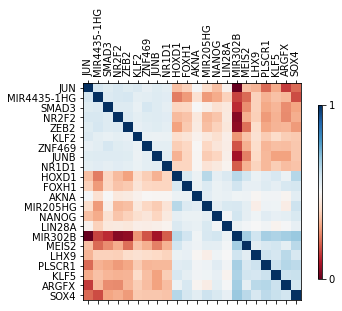

In [39]:
fig, ax = plt.subplots()
co=corr.iloc[56:78,56:78]
offset = mcolors.TwoSlopeNorm(vmin=co.min().min(),vcenter=0., vmax=1)
cax = ax.matshow(offset(co), cmap='RdBu')
plt.xticks(range(len(co.columns)), co.columns, rotation=90);
plt.yticks(range(len(co.columns)), co.columns);

# Add the colorbar legend
cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)